In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/input-data/phishing_input.csv
/kaggle/input/phishing-site-urls/phishing_site_urls.csv
/kaggle/input/extracted-features/221IT026_URLfeaturedataset.csv


In [2]:
dataset_csv = '/kaggle/input/phishing-site-urls/phishing_site_urls.csv'
df = pd.read_csv(dataset_csv)

df_new = df.sample(5000, random_state = 40)
df_new["Label"] = df_new["Label"].map({"good": "benign", "bad": "phishing"})
df_new.head(10)

,URL,Label
487758,idyllicmyanmar.com/iQBOhafE,phishing
84744,www.google.com/analytics/,benign
176454,en.wikipedia.org/wiki/John_L._Throckmorton,benign
434579,southfloridapressrelease.com/Bree-Walker-and-T...,benign
28810,casinoserver.net/wp-includes/8102022121/535235...,phishing
131261,payzpal.co.com/de/webapps/m34/home,phishing
126678,heticdocs.org/xas/os/,phishing
223308,oh-beautility.blogspot.com/,benign
153599,btjunkie.org/torrent/krizz-kaliko-discography-...,benign
302994,channel4.com/programmes,benign


In [3]:
df_new = df_new.dropna(subset=["Label"])
df_new["Label"] = df_new["Label"].map({"benign": 0, "phishing": 1})

#verify if encoding worked
print(df_new["Label"].value_counts())
print(df_new.head(10))

Label
0    3573
1    1427
Name: count, dtype: int64
                                                      URL  Label
487758                        idyllicmyanmar.com/iQBOhafE      1
84744                           www.google.com/analytics/      0
176454         en.wikipedia.org/wiki/John_L._Throckmorton      0
434579  southfloridapressrelease.com/Bree-Walker-and-T...      0
28810   casinoserver.net/wp-includes/8102022121/535235...      1
131261                 payzpal.co.com/de/webapps/m34/home      1
126678                              heticdocs.org/xas/os/      1
223308                        oh-beautility.blogspot.com/      0
153599  btjunkie.org/torrent/krizz-kaliko-discography-...      0
302994                            channel4.com/programmes      0


In [4]:
!pip install tldextract


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 3.3 MB/s eta 0:00:00


In [5]:
import tldextract
import re
import pandas as pd

suspicious_words = ["login", "secure", "bank", "verify", "account", "update", "password", "confirm"]

#IP addr
def has_ip(url):
    return 1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0

#extract various features from URL
def extract_features(url):
    extracted = tldextract.extract(url)
    
    features = {
        "url_length": len(url), 
        "domain_length": len(extracted.domain),  
        "has_ip": has_ip(url),  
        "has_https": 1 if url.startswith("https") else 0,  
        "dot_count": url.count("."),  
        "at_count": url.count("@"), 
        "slash_count": url.count("/"),  
        "question_count": url.count("?"),  
        "subdomain_count": len(extracted.subdomain.split(".")) if extracted.subdomain else 0,  
        "has_suspicious_word": 1 if any(word in url.lower() for word in suspicious_words) else 0
    }
    
    return features

# Ensure URL column has no NaN values
df_new = df_new.dropna(subset=["URL"])

df_features = df_new["URL"].apply(extract_features).apply(pd.Series)
df_final = pd.concat([df_new, df_features], axis=1)

# Save the new dataset
df_final.to_csv("new_dataset.csv", index=False)
print("Feature dataset saved.")


Feature dataset saved.


import time
import requests

api_key = 'faa49a983a32e8ac0c183d682e8c9889f3a815cdfa160426f0bd2ebebd3cfb40'

def check_url(url):
    base = 'https://www.virustotal.com/api/v3/urls'
    header = {'x-apikey': api_key}

    try:
        response = requests.post(base, headers = header, data = {'url': url}) #request to virustotal
        if response.status_code != 200:
            print(f"ERROR! {response.status_code}: {response.text}")
            return "error"

        
        scan_id = response.json()['data']['id'] #fetch the id
        time.sleep(15)

        result_url = f"https://www.virustotal.com/api/v3/analyses/{scan_id}"
        response = requests.get(result_url, headers=header)
        result_data = response.json()
        
        stats = result_data["data"]["attributes"]["stats"] #get phishing or not
        if stats["malicious"] > 0:
            return "phishing"
        elif stats["harmless"] > 0:
            return "benign"
        else:
            return "unknown"
    
    except Exception as e:
        print(f"Error checking {url}: {e}")
        return "Error"


df_new["VT_Label"] = df_new["URL"].apply(check_url)
df_new.head(5)

In [6]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("new_dataset.csv")

X = df[["URL"]]
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.to_csv("training_dataset.csv", index=False)
test_df.to_csv("testing_dataset.csv", index=False)

print("Training and testing datasets saved successfully.")

Training and testing datasets saved successfully.


In [7]:
X.head()

,URL
0,idyllicmyanmar.com/iQBOhafE
1,www.google.com/analytics/
2,en.wikipedia.org/wiki/John_L._Throckmorton
3,southfloridapressrelease.com/Bree-Walker-and-T...
4,casinoserver.net/wp-includes/8102022121/535235...


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer

df_train = pd.read_csv("training_dataset.csv")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize(url):
    return tokenizer(url, padding="max_length", max_length=256, truncation=True, return_tensors="tf")
    
df_train["Tokenized"] = df_train["URL"].apply(tokenize)

#input_ids and attention_mask
df_train["input_ids"] = df_train["Tokenized"].apply(lambda x: np.array(x["input_ids"][0]))
df_train["attention_mask"] = df_train["Tokenized"].apply(lambda x: np.array(x["attention_mask"][0]))
df_train.drop(columns=["Tokenized"], inplace=True)
df_train.to_csv("221IT026_training_tokenized.csv", index=False)

print("Tokenization complete.")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenization complete.


In [10]:
import pandas as pd
import tensorflow as tf

df_train = pd.read_csv("221IT026_training_tokenized.csv")

#input_ids and attention_mask are properly formatted
df_train["input_ids"] = df_train["input_ids"].apply(lambda x: list(map(int, x.strip("[]").split())))
df_train["attention_mask"] = df_train["attention_mask"].apply(lambda x: list(map(int, x.strip("[]").split())))

input_ids_tensor = tf.convert_to_tensor(df_train["input_ids"].tolist(), dtype=tf.int32)
attention_mask_tensor = tf.convert_to_tensor(df_train["attention_mask"].tolist(), dtype=tf.int32)

print("Tokenized data successfully loaded into tensors.")
print("Input shape:", input_ids_tensor.shape)  # Expected: (num_samples, 256)


Tokenized data successfully loaded into tensors.
Input shape: (4000, 256)


In [11]:
import tensorflow as tf
from transformers import TFBertModel
import numpy as np

# Load BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Function to process BERT embeddings in batches
def process_in_batches(input_ids, attention_mask, batch_size=64):
    num_samples = len(input_ids)
    bert_embeddings = []

    for i in range(0, num_samples, batch_size):
        batch_input_ids = tf.convert_to_tensor(input_ids[i:i+batch_size], dtype=tf.int32)
        batch_attention_mask = tf.convert_to_tensor(attention_mask[i:i+batch_size], dtype=tf.int32)

        # Get BERT embeddings for this batch
        bert_output = bert_model(batch_input_ids, attention_mask=batch_attention_mask)
        batch_embeddings = bert_output.last_hidden_state[:, 0, :].numpy()  # Take [CLS] token embedding

        bert_embeddings.append(batch_embeddings)

        print(f"Processed {i+batch_size}/{num_samples} samples...")

    return np.vstack(bert_embeddings)  # Convert list to NumPy array

# Process BERT embeddings in batches
bert_embeddings = process_in_batches(df_train["input_ids"].tolist(), df_train["attention_mask"].tolist(), batch_size=64)

print("BERT embeddings extracted successfully!")
print("Shape of embeddings:", bert_embeddings.shape)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Processed 64/4000 samples...
Processed 128/4000 samples...
Processed 192/4000 samples...
Processed 256/4000 samples...
Processed 320/4000 samples...
Processed 384/4000 samples...
Processed 448/4000 samples...
Processed 512/4000 samples...
Processed 576/4000 samples...
Processed 640/4000 samples...
Processed 704/4000 samples...
Processed 768/4000 samples...
Processed 832/4000 samples...
Processed 896/4000 samples...
Processed 960/4000 samples...
Processed 1024/4000 samples...
Processed 1088/4000 samples...
Processed 1152/4000 samples...
Processed 1216/4000 samples...
Processed 1280/4000 samples...
Processed 1344/4000 samples...
Processed 1408/4000 samples...
Processed 1472/4000 samples...
Processed 1536/4000 samples...
Processed 1600/4000 samples...
Processed 1664/4000 samples...
Processed 1728/4000 samples...
Processed 1792/4000 samples...
Processed 1856/4000 samples...
Processed 1920/4000 samples...
Processed 1984/4000 samples...
Processed 2048/4000 samples...
Processed 2112/4000 samp

In [12]:
np.save("bert_embeddings.npy", bert_embeddings)  
np.save("labels.npy", df_train["Label"].values)  

In [13]:
np.save("bert_embeddings.npy", bert_embeddings) 
np.save("labels.npy", df_train["Label"].values)  
print("Saved BERT embeddings and labels successfully!")

Saved BERT embeddings and labels successfully!


In [26]:
df_test

,URL,Label
0,maps.thefullwiki.org/Roman_Catholic_Diocese_of...,0
1,bluegrasstoday.com/8496/john-mceuen-on-wfdu/,0
2,eastbayadjusters.org/,0
3,kingstonchess.tripod.com/index.htm,0
4,boda-link.com/fw43t2d/98kj6.exe,1
...,...,...
995,transfermarkt.co.uk/en/perugia-calcio/startsei...,0
996,steamsteam.hut4.ru/,1
997,informationweek.com/blog/229204282,0
998,zimbio.com/Joannie+Rochette,0


In [23]:
X = np.expand_dims(bert_embeddings, axis=-1)
y = df_train["Label"].values 

print("Shape after reshaping for CNN:", X.shape) 

Shape after reshaping for CNN: (4000, 768, 1)


In [31]:
df_test["Tokenized"] = df_test["URL"].apply(tokenize)
df_test["input_ids"] = df_test["Tokenized"].apply(lambda x: list(x["input_ids"][0].numpy()))
df_test["attention_mask"] = df_test["Tokenized"].apply(lambda x: list(x["attention_mask"][0].numpy()))
df_test.drop(columns=["Tokenized"], inplace=True)

df_test.to_csv("221IT026_testing_tokenized.csv", index=False)

df_train = pd.read_csv("221IT026_training_tokenized.csv")
print(df_train.columns) 

df_test = pd.read_csv("221IT026_testing_tokenized.csv")
print(df_test.columns)

Index(['URL', 'Label', 'input_ids', 'attention_mask'], dtype='object')
Index(['URL', 'Label', 'input_ids', 'attention_mask'], dtype='object')


In [36]:
import numpy as np
import tensorflow as tf

def convert_to_list(value):
    if isinstance(value, str):  
        return list(map(int, value.strip("[]").replace(",", " ")split()))
    return value  

# Apply conversion only if needed
df_train["input_ids"] = df_train["input_ids"].apply(convert_to_list)
df_test["input_ids"] = df_test["input_ids"].apply(convert_to_list)

# Convert to NumPy arrays
X_train = np.array(df_train["input_ids"].tolist())  
X_test = np.array(df_test["input_ids"].tolist())
y_train = df_train["Label"].values  
y_test = df_test["Label"].values

# Expand dimensions for CNN input
X_train = np.expand_dims(X_train, axis=-1)  
X_test = np.expand_dims(X_test, axis=-1)  

# Convert to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

print(f"Training data shape: {X_train_tensor.shape}")
print(f"Testing data shape: {X_test_tensor.shape}")


Training data shape: (4000, 256, 1)
Testing data shape: (1000, 256, 1)


In [38]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
import tensorflow as tf

# Input Shape
inputs = Input(shape=(X_train.shape[1], 1))

# Convolutional Layers
x = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = layers.BatchNormalization()(x)  # Normalize
x = layers.MaxPooling1D(pool_size=2)(x)

x = layers.Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2)(x)

# Fully Connected Layers
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Compile Model
cnn_model = Model(inputs=inputs, outputs=outputs)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("CNN implementation complete")
cnn_model.summary()


CNN implementation complete


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 254, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 254, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 127, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 125, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 125, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 62, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,015,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,042,305 (3.98 MB)

 Trainable params: 1,041,665 (3.97 MB)

 Non-trainable params: 640 (2.50 KB)

In [40]:
batch_norm_layers = [layer for layer in cnn_model.layers if isinstance(layer, layers.BatchNormalization)]
batch_norm_outputs = [layer.output for layer in batch_norm_layers]

norm_model = Model(inputs=cnn_model.input, outputs=batch_norm_outputs)


In [46]:
import matplotlib.pyplot as plt
import numpy as np

batch_size = 32
epochs = 20  


class BatchNormCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        batch_norm_activations = norm_model.predict(X_train_tensor[:batch_size])
        for i, activation in enumerate(batch_norm_activations):
            plt.figure(figsize=(8, 4))
            plt.hist(activation.flatten(), bins=50, alpha=0.75)
            plt.title(f'Final Batch Norm Activation Distribution - Layer {i+1}')
            plt.xlabel('Activation Values')
            plt.ylabel('Frequency')
            plt.grid(True)

            filename = f"221IT026_Final_Norm_Layer{i+1}.jpeg"
            plt.savefig(filename, dpi=300)
            plt.close()

            print(f"Saved {filename}")

import time

start_train_time = time.time()
# Train the Model
history = cnn_model.fit(
    X_train_tensor, y_train_tensor,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_tensor, y_test_tensor),
    callbacks=[BatchNormCallback()]
)


end_train_time = time.time()
total_training_time = end_train_time - start_train_time
print("Training Complete")
print(f"Total Training Time: {total_training_time:.2f} seconds")


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9070 - loss: 0.2259 - val_accuracy: 0.6970 - val_loss: 0.7487
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8941 - loss: 0.2426 - val_accuracy: 0.8100 - val_loss: 0.5273
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9266 - loss: 0.2040 - val_accuracy: 0.7790 - val_loss: 0.5855
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9139 - loss: 0.1970 - val_accuracy: 0.6960 - val_loss: 0.6929
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9233 - loss: 0.1985 - val_accuracy: 0.6940 - val_loss: 0.7093
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9130 - loss: 0.2051 - val_accuracy: 0.7830 - val_loss: 0.6683
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9304 - loss: 0.1746 - val_accuracy: 0.7710 - val_loss: 0.6183
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9274 - loss: 0.1909 - val_accu

In [47]:
cnn_model.save("221IT026_CNN_Model.h5")
print("Model saved")


Model saved


In [48]:
df_time = pd.DataFrame({"Metric": ["Total Training Time (seconds)"], "Value": [total_training_time]})

excel_filename = "221IT026-trainingtime.xlsx"
df_time.to_excel(excel_filename, index=False)

print(f"Training time saved in {excel_filename}")

df_history = pd.DataFrame(history.history)
df_history.to_csv("221IT026_Training_History.csv", index=False)

print("Training history saved")



Training time saved in 221IT026-trainingtime.xlsx
Training history saved


In [49]:
import pandas as pd

#save training details
df_metrics = pd.DataFrame({
    "Epoch": list(range(1, len(history.history["loss"]) + 1)),
    "Training Accuracy": history.history["accuracy"],
    "Validation Accuracy": history.history["val_accuracy"],
    "Training Loss": history.history["loss"],
    "Validation Loss": history.history["val_loss"]
})

df_metrics.to_excel("221IT026_training_metrics.xlsx", index=False)
print("Training accuracy and loss saved successfully to Excel!")


Training accuracy and loss saved successfully to Excel!


In [50]:
for layer in cnn_model.layers:
    print(f"Layer: {layer.name}")
    
    if layer.get_weights():
        weights, biases = layer.get_weights()
        print(f"  Weights shape: {weights.shape}")
        print(f"  Biases shape: {biases.shape}")
    print("-" * 10)


Layer: input_layer_1
----------
Layer: conv1d_2
  Weights shape: (3, 1, 64)
  Biases shape: (64,)
----------
Layer: batch_normalization_3


ValueError: too many values to unpack (expected 2)

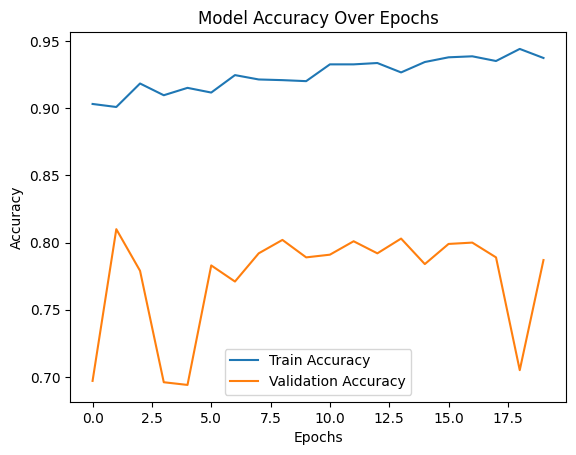

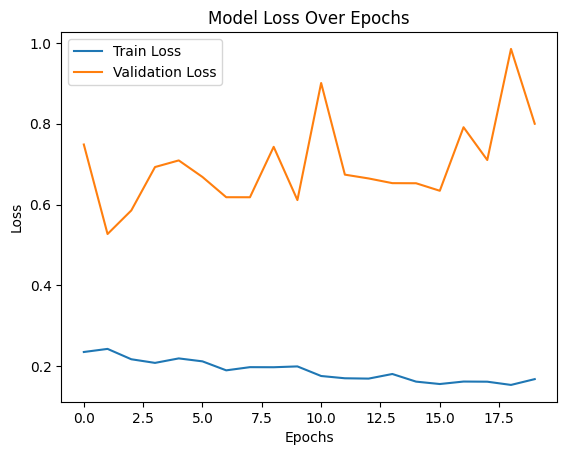

In [51]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.savefig("221IT026-AccuracyGraph.jpeg")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.savefig("221IT026-LossGraph.jpeg")
plt.show()
